In [1]:
#for local
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [2]:
%load_ext autoreload
%autoreload 2
from datetime import datetime
import importlib
import numpy as np
import logging
import os
import random
import shutil
import time
import torch
from typing import Any
import yaml
from rdkit import RDLogger
from generator import Generator
from language import Language, MolLanguage
from node import SurrogateNode, SentenceNode, MolSentenceNode
from utils import add_sep, class_from_package, make_logger

RDLogger.DisableLog('rdApp.*') # use debug: true to log invalid mols

def read_yaml(yaml_path: str) -> tuple[Generator, dict[str, Any]]:
    with open(os.path.join(repo_root, yaml_path)) as f:
        conf = yaml.safe_load(f)

    output_dir=os.path.join(repo_root, "sandbox", conf["output_dir"], datetime.now().strftime("%m-%d_%H-%M")) + os.sep
    file_level = logging.DEBUG if conf.get("debug") else logging.INFO
    logger = make_logger(output_dir, file_level=file_level)

    if "seed" in conf:
        seed = conf["seed"]
    else:
        seed = int(time.time()) % (2**32)
    logger.info("seed: " + str(seed))
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    generator_args = conf.get("generator_args", {})

    transition_args = conf.get("transition_args", {})
    if "model_dir" in transition_args:
        transition_args["model_dir"] = os.path.join(repo_root, transition_args["model_dir"])
    lang_path = conf.get("lang_path")
    if lang_path is None:
        lang_name = os.path.basename(os.path.normpath(transition_args["model_dir"])) + ".lang"
        lang_path = add_sep(transition_args["model_dir"]) + lang_name
    lang = Language.load(lang_path)
    transition_class = class_from_package("transition", conf["transition_class"])
    transition = transition_class(lang=lang, logger=logger, device=conf.get("device"), **transition_args)

    reward_class = class_from_package("reward", conf.get("reward_class"))
    reward = reward_class(**conf.get("reward_args", {}))
    
    if "policy_class" in conf:
        policy_class = class_from_package("policy", conf.get("policy_class"))
        policy = policy_class(**conf.get("policy_args", {}))
        generator_args["policy"] = policy

    filter_settings = conf.get("filters", [])
    filters = []
    for s in filter_settings:
        filter_class = class_from_package("filter", s.pop("filter_class"))
        filters.append(filter_class(**s))

    if "node_class" in conf:
        node_class = class_from_package("node", conf.get("node_class"))
    elif issubclass(lang.__class__, MolLanguage):
        node_class = MolSentenceNode
    elif issubclass(lang.__class__, Language):
        node_class = SentenceNode
    if node_class == MolSentenceNode:
        MolSentenceNode.use_canonical_smiles_as_key = conf.get("use_canonical_smiles_as_key", True)
   
    if type(conf.get("root")) == list:
        root = SurrogateNode()
        for s in conf.get("root"):
            node = node_class.node_from_key(lang=lang, string=s, device=conf.get("device"))
            root.add_child(action=s, child=node)
    else:
        root = node_class.node_from_key(lang=lang, string=conf.get("root", ""), device=conf.get("device"))
    
    generator_class = class_from_package("generator", conf.get("generator_class", "MCTS"))
    generator = generator_class(root=root, transition=transition, reward=reward, filters=filters, output_dir=output_dir, logger=logger, **generator_args)

    src = os.path.join(repo_root, yaml_path)
    dst = os.path.join(output_dir, "setting.yaml")
    shutil.copy(src, dst)
    return generator, conf

def generate_and_analyze(generator, conf):
    generator.generate(time_limit=conf.get("time_limit"), max_generations=conf.get("max_generations"))
    generator.plot(**conf.get("plot_args", {}))
    generator.analyze()

def queue_generations(*args: str):
    for yaml_path in args:
        generator, conf = read_yaml(yaml_path)
        generate_and_analyze(generator, conf)

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for class boost::shared_ptr<class RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
c:\Users\fsfsf\anaconda3\envs\v3-forge\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\fsfsf\anaconda3\envs\v3-forge\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 指定されたプロシージャが見つかりません。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


seed: 1751056356
Starting generation...
<best reward updated> order: 1, time: 0.00, reward: -0.5519, node: COc1ccc(Br)cc1/C=C/C(=O)NC[C@@H](C1CC1)[NH+](C)C
<best reward updated> order: 2, time: 0.30, reward: 0.5538, node: Nc1ccccc1C(=O)NNC(=O)Cc1ccccc1Cl
<best reward updated> order: 5, time: 0.33, reward: 0.7670, node: C(=C1\SC(c2ccccc2)=NN1Cc1ccccc1)\c1ccccc1
<best reward updated> order: 39, time: 0.71, reward: 0.7959, node: O[C@@H](c1ccc(Cl)s1)[C@@H]1CCC[C@@]1(O)Cc1cccs1
<best reward updated> order: 95, time: 1.30, reward: 0.8051, node: O[C@@H](c1sccc1Br)c1sccc1I
generated: 100, time: 1.33, average over 100: 0.1427
generated: 200, time: 2.50, average over 100: 0.3640
<best reward updated> order: 252, time: 3.09, reward: 0.8056, node: O=S(=O)(Oc1ccc2oc3ccccc3c2c1)c1ccccc1-c1ccc(Cl)cc1
<best reward updated> order: 272, time: 3.30, reward: 0.8148, node: O=S(=O)(Oc1cc(Oc2ccccc2)ccc1Oc1ccc(Br)cc1)c1ccccc1
generated: 300, time: 3.65, average over 100: 0.5137
generated: 400, time: 4.74, ave

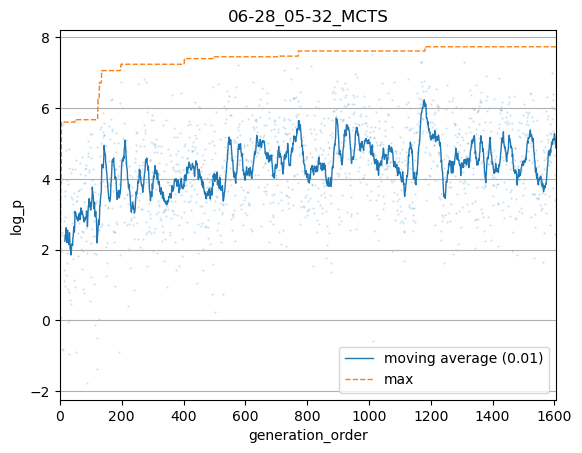

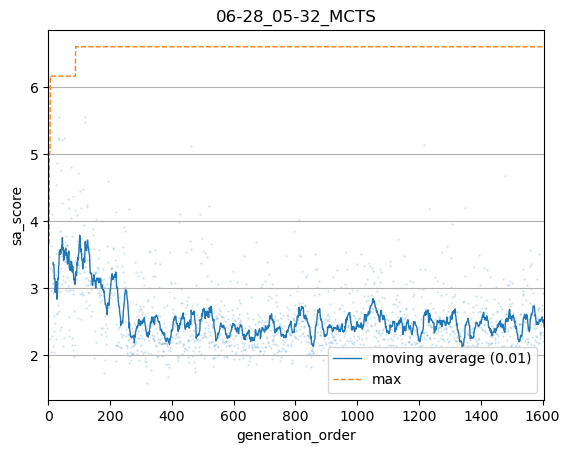

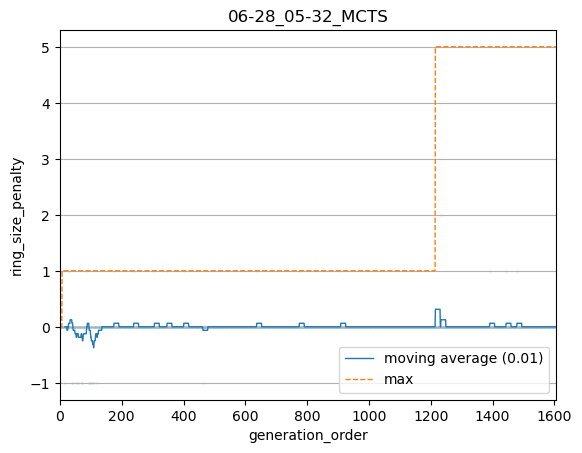

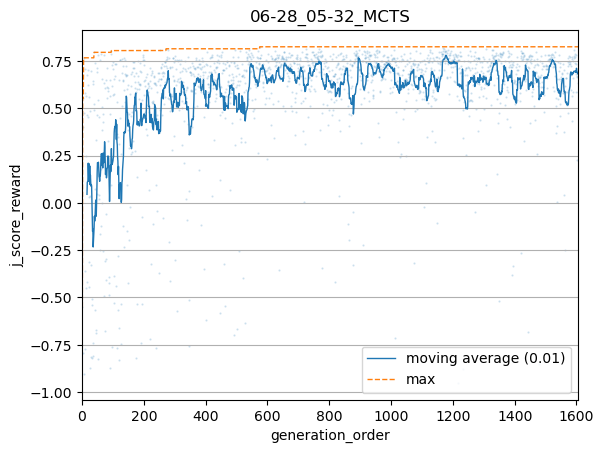

number of generated nodes: 1605
valid rate: 0.9541231126596981
unique rate: 0.9779326364692218
node_per_sec: 80.2329522116158
best_reward: 0.8252738558021814
average_reward: 0.5847086084642568


In [3]:
# start generation
c1 = "config/mcts_d_score_replication.yaml"
c2 = "config/mcts_helm.yaml"
c3 = "config/mcts_smiles.yaml"
c4 = "config/model_test.yaml"
c5 = "config/mcts_d_score.yaml"
c6 = "config/mcts_j_score.yaml"
generator, conf = read_yaml(c3)
generate_and_analyze(generator, conf)
# queue_generations(c1, c2)

In [ ]:
#continue search
generator.generate(time_limit=conf.get("time_limit") - generator.passed_time, max_generations=conf.get("max_generations") - len(generator.unique_keys))
generator.plot(**conf.get("plot_args", {}))
generator.analyze()

In [16]:
#save mcts
save_path = generator.output_dir() + "save.mcts"
generator.save(save_path)

In [ ]:
#load generator and yaml
load_dir = "generation_result/06-26_08-51/"
generator, conf = read_yaml("sandbox/" + load_dir + "setting.yaml")
generator = Generator.load(load_dir + "save.mcts", generator.transition)

In [ ]:
#time test
import cProfile
import pstats

profiler = cProfile.Profile()
profiler.enable()
read_yaml(c2)
profiler.disable()

stats = pstats.Stats(profiler)
stats.sort_stats("cumtime").print_stats(100)